# Multidimensional Newton’s method

Most real-life equations are nonlinear — everything in the real world "goes nonlinear" if you push it hard enough.  But we can still use linear algebra to solve nonlinear equations!

The key fact is that **derivatives** represent **linear approximations** of functions, so you can solve even *nonlinear problems* by a **sequence of linear approximations** using derivatives.

The most famous example of this is [Newton’s method](https://en.wikipedia.org/wiki/Newton%27s_method).  Given a system of nonlinear equation
$$
\vec{f}(\vec{x}) = \vec{0}
$$
representing $n$ equations $\vec{f} \in \mathbb{R}^n$ in $n$ unknowns $\vec{x} \in \mathbb{R}^n$, the linear approximation around any given $\vec{x}$ is
$$
\vec{f}(\vec{x} + \delta\vec{x}) ≈ \vec{f}(\vec{x}) + J\delta\vec{x} \, ,
$$
where $J$ is the **Jacobian matrix** of $\vec{f}(\vec{x})$: $J_{ij} = \partial f_i / \partial x_j$.   By setting this *approximation* to zero, we obtain a **Newton step**
$$
\delta\vec{x} = \boxed{-J^{-1} \vec{f}(\vec{x})} \, .
$$
Performing a sequence of these steps gives us Newton's method:
```jl
x = initial guess
while not converged
    x = x - J(x) \ f(x)
end
```
If you give it a reasonable starting guess, it converges amazingly fast: asymptotically, it **doubles the number of accurate digits** on **every step**.

## Example application: The Thomson problem

The [Thomson problem](https://en.wikipedia.org/wiki/Thomson_problem) is one of the most famous unsolved problems in mathematics: given $N$ equal **point charges** constrained to lie on a sphere, **repelling each other** by the usual inverse-square ["Coulomb" force](https://en.wikipedia.org/wiki/Coulomb%27s_law) law, what is their [equilibrium configuration](https://en.wikipedia.org/wiki/Mechanical_equilibrium) where all the forces are zero and potential energy is minimized?

Rigorous solutions on a sphere in 3 dimensions are known for only a few values of $N$!

A much easier version of the Thomson problem is to formulate it in **2 dimensions** for point charges sliding (without friction) on a **circle**:

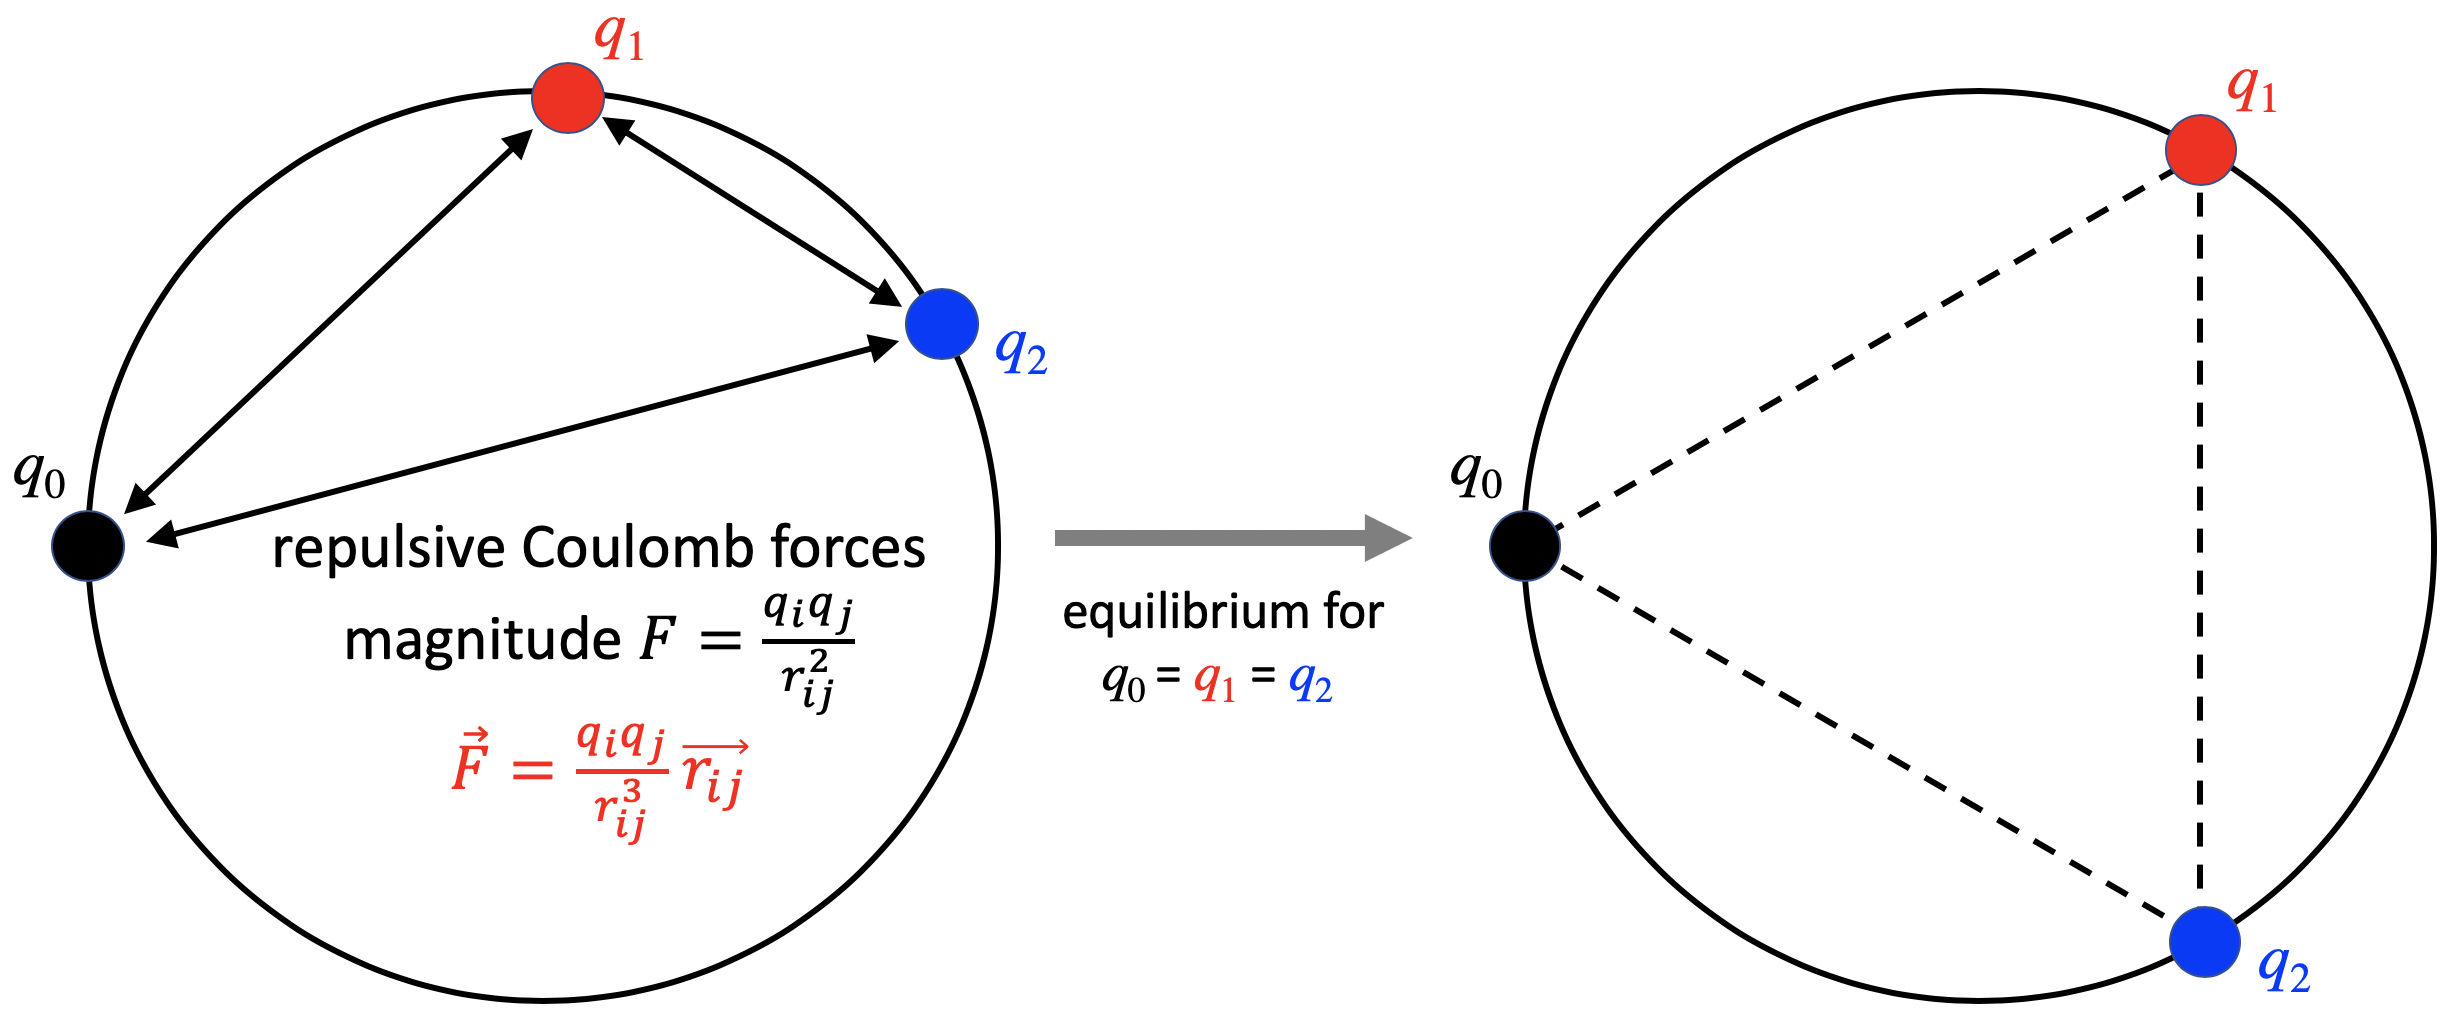

If all the charges $q_i$ are equal, then the solution is simply that they lie on the vertices of a [regular N-vertex polygon](https://en.wikipedia.org/wiki/Regular_polygon), which allows them to be **as far from one another as possible**.

Let's pretend we don't know that solution, or have unequal charges, or perhaps we are "warming up" to solve the problem in 3d.   Then we could attack the problem numerically in two basic ways:

* We could have a vector of $N-1$ unknown angles $\vec{\theta}$ (fixing $q_0$ to lie at $[-1,0]$), compute the $N-1$ **tangential forces** $\vec{f}(\vec{\theta})$ by the inverse-square law, and then solve for the **root** $\vec{f}(\vec{\theta}) = \vec{0}$ by **Newton’s method**.

* We could instead compute the potential energy $V(\vec{\theta})$ and **minimize** over the $N-1$ angles, perhaps by [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent).

In this notebook, we'll use the former approach: solve for the configuration with **tangential forces = 0** using Newton iterations.

### Computing the forces

Let's write a little Julia function `forces(θ⃗, q⃗)` to compute the tangential forces on the $N-1$ charges `q⃗[1], q⃗[2], …` ($= q_1, q_2, \ldots$) given the angles `θ⃗[1], θ⃗[2], …` ($= \theta_1, \theta_2, \ldots$), fixing $q_0$ to lie at $(-1,0)$ as in the diagram above.

(If you're wondering how I typed a variable name like `θ⃗`, it's easy: just type `\theta<TAB>` followed by `\vec<TAB>` using tab completion.   It's nice to be able to write programs using a notation that mirrors how we might write it in mathematics!)

In [1]:
using LinearAlgebra # for the norm(x⃗) function = ‖x⃗‖ = √x⃗ᵀx⃗

function forces(θ⃗, q⃗)
    x⃗₀ = [-1, 0]  # q₀ is fixed at (-1,0)
    q₀ = 1
    F⃗ = map(1:length(θ⃗)) do i
        x⃗ᵢ = [cos(θ⃗[i]), sin(θ⃗[i])]  # position of charge i on unit circle

        # inverse-square force law: F⃗ = qᵢqⱼ r̂ᵢⱼ / rᵢⱼ² = qᵢqⱼ r⃗ᵢⱼ / rᵢⱼ³
        
        # force from x⃗₀:
        F⃗ᵢ = (x⃗ᵢ - x⃗₀) * (q⃗[i] * q₀ / norm(x⃗ᵢ - x⃗₀)^3)

        for j = 1:length(θ⃗)  # add forces from other charges
            if i ≠ j
                x⃗ⱼ = [cos(θ⃗[j]), sin(θ⃗[j])]
                F⃗ᵢ += (x⃗ᵢ - x⃗ⱼ) * (q⃗[i] * q⃗[j] / norm(x⃗ᵢ - x⃗ⱼ)^3)
            end
        end
        
        # construct force component in tangential direction
        F⃗ᵢ ⋅ [-x⃗ᵢ[2], x⃗ᵢ[1]]  # dot product with tangent vector [-sin, cos]
    end
    return F⃗
end

forces (generic function with 1 method)

In [2]:
forces([1,2], [1,1])

2-element Vector{Float64}:
 -1.1101484801582246
  0.23390271383615946

### Computing the Jacobian

Computing derivatives is straightforward in principle, but can be pretty tedious in practice to carry out by hand.

Fortunately, nowadays there are lots of tools for [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) in many programming languages: given a function like our `forces` function above, they can *automatically* compute any derivative we want *exactly*.

Julia has [lots of automatic-differentiation packages](https://juliadiff.org/) with different strengths and weaknesses.  (In Python, the most famous ones are [JAX](https://github.com/google/jax) and [autograd](https://github.com/HIPS/autograd).)

Here, we will use the [ForwardDiff package](https://github.com/JuliaDiff/ForwardDiff.jl) in Julia to compute the whole Jacobian matrix at once for us.   (For a gentle introduction to how ForwardDiff works, see e.g. [Matrix Calculus Lecture 5](https://github.com/mitmath/matrixcalc#lecture-5-jan-21).)

In [3]:
using ForwardDiff

This provides a function `ForwardDiff.jacobian(f, x)` that computes the Jacobian of a function `f(x)` at `x`.

Here, our `forces` function takes *two* arguments `θ⃗` and `q⃗`, but we only want the derivatives with respect to the angles `θ⃗`.   We can wrap a two-argument function in a 1-argument function by [using a closure/anonymous function](https://m3g.github.io/JuliaNotes.jl/v0.3/closures/) `θ⃗ -> forces(θ⃗, q⃗)`, which effectively tells ForwardDiff to ignore `q⃗` (treat it as a constant parameter):

In [4]:
ForwardDiff.jacobian(θ⃗ -> forces(θ⃗, [1,1]), [1,2])

2×2 Matrix{Float64}:
 -2.23542   2.00797
  2.00797  -3.36162

### Newton's method

Given a function and it's Jacobian, Newton's method is trivial to implement: just a loop of updates `θ⃗ = θ⃗ - J \ f⃗`.

Here, we'll run 8 iterations of Newton, starting at `θ⃗ = [1,2]`, using Julia's handy [`@show` macro](https://docs.julialang.org/en/v1/base/base/#Base.@show) to print out the values of the angles and forces at each step:

In [5]:
θ⃗ = [1,2] # initial "guess"
q⃗ = [1,1]

for iteration = 1:8
    @show θ⃗ .* (180/π)
    @show f⃗ = forces(θ⃗, q⃗)
    J = ForwardDiff.jacobian(θ⃗ -> forces(θ⃗, q⃗), θ⃗)
    θ⃗ = θ⃗ - J \ f⃗
    println() # print a blank line
end

# show the final values:
@show θ⃗ .* (180/π)
@show f⃗ = forces(θ⃗, q⃗);

θ⃗ .* (180 / π) = [57.29577951308232, 114.59155902616465]
f⃗ = forces(θ⃗, q⃗) = [-1.1101484801582246, 0.23390271383615946]

θ⃗ .* (180 / π) = [3.6272305871204433, 86.52081245119722]
f⃗ = forces(θ⃗, q⃗) = [-0.43561688723970665, 0.10464402757105067]

θ⃗ .* (180 / π) = [-49.452387906553305, 60.63693449859814]
f⃗ = forces(θ⃗, q⃗) = [-0.08648212799856117, 0.04386916996774379]

θ⃗ .* (180 / π) = [-60.229832611790215, 59.28633181111147]
f⃗ = forces(θ⃗, q⃗) = [-0.0010745673439266357, 0.005015882462263949]

θ⃗ .* (180 / π) = [-59.99776766680708, 60.00252816028715]
f⃗ = forces(θ⃗, q⃗) = [-8.130415691087745e-6, -1.185710069834256e-5]

θ⃗ .* (180 / π) = [-60.000000012297534, 60.00000002720289]
f⃗ = forces(θ⃗, q⃗) = [2.174794511144995e-10, -2.800611131892339e-10]

θ⃗ .* (180 / π) = [-59.999999999999986, 60.00000000000001]
f⃗ = forces(θ⃗, q⃗) = [-1.6653345369377348e-16, 5.551115123125783e-17]

θ⃗ .* (180 / π) = [-60.00000000000001, 60.00000000000001]
f⃗ = forces(θ⃗, q⃗) = [1.1102230246251565e-16, -1

Notice how quickly the forces decrease, and how quickly the angles converge to $\theta = \pm \pi / 3 = \pm 60^\circ$!

Once the solution is even *slightly* close to the correct answer, the number of correct digits **double** on each step of Newton’s method.

Eventually, the answers are limited by [roundoff error](https://en.wikipedia.org/wiki/Round-off_error) to about **15–16 digits**.

(Note: there is also *another solution* where the positions of $q_1$ and $q_2$ are *swapped*.  In general, *which* solution Newton’s method converges to — or even whether it converges at all — depends strongly on the *initial guess*.)

### Visualizing the Newton iterations & Thomson solutions

It is nice to plot these solutions graphically, and even to animate the progress of the Newton iterations.

First, let's write a function `plotcharges(θ⃗)` to plot the locations of the charges at the angles `θ⃗` using the [PyPlot.jl package](https://github.com/JuliaPy/PyPlot.jl), which is a thin wrapper around Python's [matplotlib](https://matplotlib.org/):

In [6]:
using PyPlot

function plotcharges(θ⃗)
    gca().add_patch(plt.Circle((0,0), 1.0, clip_on=false, fill=false))
    plot(-1, 0, "ko")
    text(-1 + 0.05, 0, "q₀")
    axis("equal")
    for (i,θ) in enumerate(θ⃗)
        plot(cos(θ), sin(θ), "o")
        text(cos(θ)+0.1, sin(θ), "q" * ('₀' + i))
    end
    xlabel(L"x")
    ylabel(L"y")
end

plotcharges (generic function with 1 method)

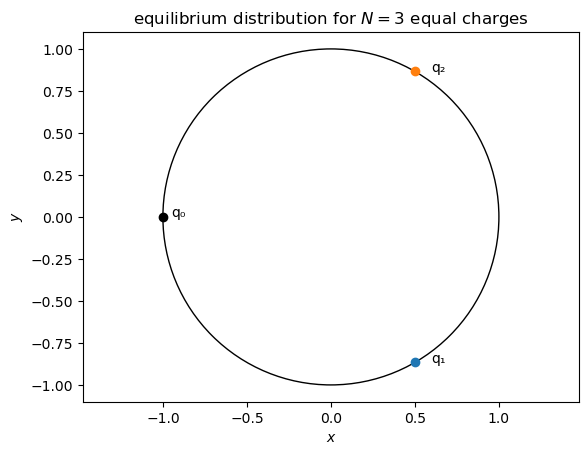

PyObject Text(0.5, 1.0, 'equilibrium distribution for $N=3$ equal charges')

In [7]:
plotcharges(θ⃗)
title(L"equilibrium distribution for $N=3$ equal charges")

Next, we'll create an interactive animation of the Newton iterations and the Thomson solutions using Julia's [Interact.jl package](https://github.com/JuliaGizmos/Interact.jl), which allows us to set up "slider" controls for the number of Newton steps, the number of charges, and the values of the charges $q_1$ and $q_2$:

In [8]:
using Interact

WebIO._IJuliaInit()

In [9]:
fig = figure()
@manipulate for iterations = slider(0:16, value=0, label="Newton iterations"),
                q₁ in slider([0.1,1,2,4,8], value=1, label="q₁"),
                q₂ in slider([0.1,1,2,4,8], value=1, label="q₂"),
                N in slider(2:10, value=3, label="Number of particles")
    n = N-1
    θ⃗ = [1:n;] ./ n
    q⃗ = ones(n)
    q⃗[1] = q₁
    if n > 1
        q⃗[2] = q₂
    end
    for iteration = 1:iterations
        f⃗ = forces(θ⃗, q⃗)
        J = ForwardDiff.jacobian(θ⃗ -> forces(θ⃗, q⃗), θ⃗)
        θ⃗ = θ⃗ - J \ f⃗
    end
    f⃗ = forces(θ⃗, q⃗)
    withfig(fig) do
        plotcharges(θ⃗)
        title("$N particles, forces = $(round.(f⃗, sigdigits=3))")
    end
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["Newton iterations"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 16, :min => 0, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Int64} with 2 listeners. Value:
0, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/stevenj/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/stevenj/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/stevenj/.julia/packages/InteractBase/o1I6G/src/../assets/all.js"), Asset("css", nothing, "/Users/stevenj/.julia/packages/InteractBase/o1I6G/src/../assets/style.css"), Asset("css", nothing, "/Users/stevenj/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000010d75d7b0, Task (runnable) @0x000000010d75d7b0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0\",\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"2642626295010531411\",\"id\":\"7118009537228556294\",\"type\":\"observable\"}),\"